# Simple MLP demo

This notebook demonstrates how to create a simple MLP for recognizing phonemes from speech. To do this, we will use a training dataset prepared in a different notebook titled *VoxforgeDataPrep*, so take a look at that before you start working on this demo.

In this example, we will use the excellent [Keras](http://keras.io/) library which depends upon either Theano or TensorFlow, so you will need to install those as well. Just follow the isntructions on the Keras website - it is recommended to use the freshest, Github versions of both Keras and Theano.

I also have the convinence of using the GPU for the actual computation. This code will work just as well on the CPU, but it's much faster on a good GPU.

We start by importing numpy (for loading and working with the data) and the neccessary Keras classes. Feel free to add more here if you wish to experiment with them.

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adadelta

Using Theano backend.
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN (CNMeM is enabled)


First let's load our data. In the *VoxforgeDataPrep* notebook, we created to arrays - inputs and outputs. The input nas the dimensions (num_samples,num_features) and the output is simply 1D vector of ints of length (num_samples). In this step, we split the data into training (80%), dev (10%) and test (10%) portions and save the indices referencing these parts.

In [2]:
inputs=np.load('../data/mfcc_in_norm.npy')
output_dec=np.load('../data/mfcc_out.npy')

num=inputs.shape[0]

p1=int(num*0.8)
p2=int(num*0.9)

train_idx=range(0,p1)
dev_idx=range(p1,p2)
test_idx=range(p2,num)

To improve the context sensitivity of the model, we take 7 samples (3 before and 3 after) from the input and provide them to the network all at once. This increases our input size from 39 to 273 elements, which is still managable.

In [3]:
def expandTimeWindow(data, time_before, time_after):

    newdata = []

    last_win = data.shape[0] - 1

    for w in range(data.shape[0]):

        newwin = []
        for x in range(w - time_before, w + time_after + 1):
            w = x
            if(w < 0):
                w = 0
            if(w > last_win):
                w = last_win
            newwin.append(data[w])
        newdata.append(np.concatenate(newwin))

    return np.vstack(newdata)

inputs=expandTimeWindow(inputs,3,3)

Next we define some constants for our program. Input and output dimensions can be inferred from the data, but the hidden layer size has to be defined manually.

We also redefine our outputs as a 1-of-N matrix instead of an int vector. The old outputs were simply a list of integers (from 0 to 39) defining the phoneme (as listed in ../data/phones.list) class for each sample given at input. The new matrix has dimensions (num_samples, num_classes) and is mostly 0 with a single 1 put in place corresponding to the class index in the old output vector.

In [4]:
input_dim=inputs.shape[1]
output_dim=np.max(output_dec)+1

hidden_num=256

outputs=np.zeros((num,output_dim))
outputs[range(0,num),output_dec]=1

In [13]:
print 'Samples num: {}'.format(num)
print 'Input size: {}'.format(input_dim)
print 'Output size (number of classes): {}'.format(output_dim)

Samples num: 1438610
Input size: 273
Output size (number of classes): 40


## Model definition

Here we define our model using the Keras interface. There are two main model types in Keras: sequential and graph. Sequential is much more common and easy to use, so we start with that.

Next we define the MLP topology. Here we have 3 layers: input, hidden and output. They are interconnected with two sets of *Dense* weight connections and a layer of activation functions after these weights. When defining the *Dense* weight layers, we need to provide the size: input and output are neccessary only for the first layer, subsequent layers use the output size of the previous layer as their input size.

We also define the type of optimizer and loss function we want to use. There are a few optimizers to choose from in the library and they are all interchangable. The differences between them are not too large in this example (feel free to experiment). The loss function chosen here is the cross-entropy function. Another option would be the simpler MSE (mean square error). Again, there doesn't seem to be much of a difference, but cross-entropy does seem like performing a bit better overall.

In [6]:
model = Sequential()

model.add(Dense(input_dim=input_dim,output_dim=hidden_num))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=output_dim))
model.add(Activation('softmax'))

#optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
optimizer= Adadelta()
loss='categorical_crossentropy'

After defining the model and all its parameters, we can compile it. This literally means compiling, because the model is converted into C++ code in the background and compiled with lots of optimizations to work as efficiently as possible. The process can take a while, but is worth the added speed in training.

In [7]:
model.compile(loss=loss, optimizer=optimizer)

Finally, we can start training the model. We provide the training function both training and validation data and define a few parameters: batch size and number of training epochs. Changing the batch size can affect both the training speed and final accuracy. This value is also closely related to the number of epochs. Generally, you want to run the training for as many epochs as needed for the model to converge on some value. The value of 100 should be fine for a quick comparison but up to 1k may be necessary to be abolutely sure (especially when testing larger models).

Setting the verbose value to 2 makes more sense in notebooks, but leaving it at one creates a nice progress bar if you run the program from the console.

In [8]:
val=(inputs[dev_idx],outputs[dev_idx])

hist=model.fit(inputs[train_idx], outputs[train_idx], batch_size=256, nb_epoch=100, verbose=2, validation_data=val)

Train on 1150888 samples, validate on 143861 samples
Epoch 1/100
5s - loss: 1.5383 - val_loss: 1.4148
Epoch 2/100
5s - loss: 1.2941 - val_loss: 1.2930
Epoch 3/100
5s - loss: 1.2130 - val_loss: 1.2277
Epoch 4/100
5s - loss: 1.1694 - val_loss: 1.2165
Epoch 5/100
5s - loss: 1.1410 - val_loss: 1.2018
Epoch 6/100
5s - loss: 1.1208 - val_loss: 1.1821
Epoch 7/100
5s - loss: 1.1050 - val_loss: 1.1629
Epoch 8/100
5s - loss: 1.0920 - val_loss: 1.1483
Epoch 9/100
5s - loss: 1.0814 - val_loss: 1.1693
Epoch 10/100
5s - loss: 1.0722 - val_loss: 1.1468
Epoch 11/100
5s - loss: 1.0648 - val_loss: 1.1589
Epoch 12/100
5s - loss: 1.0580 - val_loss: 1.1478
Epoch 13/100
5s - loss: 1.0519 - val_loss: 1.1387
Epoch 14/100
5s - loss: 1.0464 - val_loss: 1.1328
Epoch 15/100
5s - loss: 1.0416 - val_loss: 1.1364
Epoch 16/100
5s - loss: 1.0370 - val_loss: 1.1306
Epoch 17/100
5s - loss: 1.0334 - val_loss: 1.1353
Epoch 18/100
5s - loss: 1.0295 - val_loss: 1.1327
Epoch 19/100
5s - loss: 1.0266 - val_loss: 1.1258
Epoch 

The training method returns an object that contains the trained model parameters and the training history:

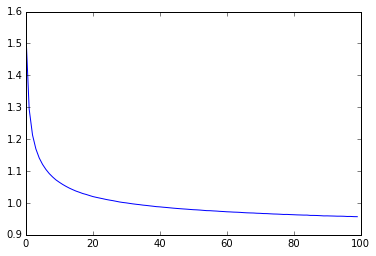

In [17]:
import matplotlib.pyplot as P
%matplotlib inline

P.plot(hist.history['loss'])

You can get better graphs and more data if you overload the training callback method, which will provide you with the model parameters after each epoch during training.

After the model is trained, we can easily test it using the evaluate method. The show_accuracy argument is required to compute the accuracy of the decision variable. The returned result has a 2-element list, where the first value is the loss of the model on the test data and the second is the accuracy, around 70% in this case:

In [9]:
res=model.evaluate(inputs[test_idx],outputs[test_idx],batch_size=256,show_accuracy=True,verbose=0)

In [16]:
print 'Loss: {}'.format(res[0])
print 'Accuracy: {:%}'.format(res[1])

Loss: 1.00941736841
Accuracy: 69.926526%


## Further steps

You can play around with the different parameters and network topologies. The results aren't going to be much better using this type of model. Using recurrent topologies (e.g. LSTM) can work better, as well as providing more data. Crucially, however, framewise phoneme classification is not the best benchmark to test and isn't the most useful. Further notebooks will go into other technuiques for getting closer to the best speech recognition can provide.